In [159]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# COMM477 Pricing Asset using Monte Carlo Simulation 

# Reading the Data

In [160]:
# Load underlying asset's historical price data
data = pd.read_excel('data/index_price.xlsx')
data.head()

,Date,Price
0,2019-10-31,100.00
1,2019-11-01,100.07
2,2019-11-04,99.83
3,2019-11-05,99.29
4,2019-11-06,100.12


#### Turning Price into Float Data Type

In [161]:

# data['Price']= data['Price'].str.replace('$', '').astype(float) 


### Converting Date to datetime Datatype

In [162]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%y')

In [163]:
data.dtypes

Date     datetime64[ns]
Price           float64
dtype: object

### Sorting data in order

In [164]:
data.sort_values('Date', inplace=True)

In [165]:
data.head()

,Date,Price
0,2019-10-31,100.00
1,2019-11-01,100.07
2,2019-11-04,99.83
3,2019-11-05,99.29
4,2019-11-06,100.12


In [166]:
# creating returns columns 
data["Returns"] = np.log(1+data['Price'].pct_change()).dropna()

# setting date as the index
data.set_index('Date', inplace=True)


In [167]:
data.tail()

,Price,Returns
Date,,
2024-04-02,119.41,-0.014632
2024-04-03,118.80,-0.005122
2024-04-04,118.47,-0.002782
2024-04-05,119.67,0.010078
2024-04-08,119.99,0.002670


### Calculating Variables

In [168]:
mu, sig = data['Returns'].mean(), data['Returns'].std()

sim_rets = np.random.normal(mu,sig,252)

initial = data['Price'].iloc[-1]

sim_prices = initial * (sim_rets + 1).cumprod()


In [169]:
mu, sig = data['Returns'].mean(), data['Returns'].std()
initial = data['Price'].iloc[-1]
ending_prices = []
final_returns = [] 

# Monte Carlo Simulation

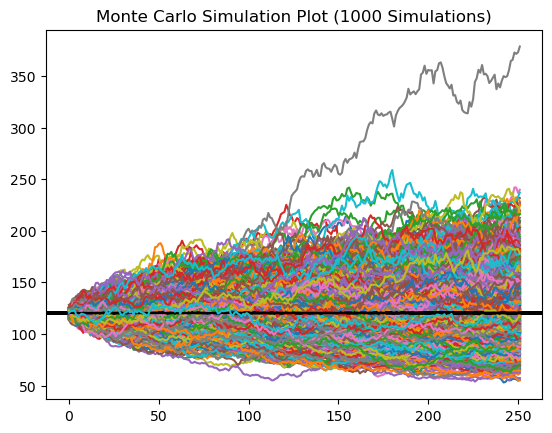

In [170]:
num_sims = 1000 # number of simulations

for i in range(num_sims):
    sim_rets = np.random.normal(mu, sig, 252)
    sim_prices = initial * (sim_rets + 1).cumprod()
    ending_prices.append(sim_prices[-1])
    
    # Calculate the underlying performance as a percentage
    performance = (sim_prices[-1] / initial - 1) * 100
    
    # applying the strucutre mentioned in the product overview 
    if performance > 152:
        final_return = initial * (1 + (performance - 152) / 100 + 1) # Principal + 100% of the performance above 152%
    elif 100 < performance <= 152:
        final_return = initial * (1 + 0.52) # Principal + 52%
    elif 80 < performance <= 100:
        final_return = initial 
    else: 
        final_return = initial * (performance / 100 + 1)  # if performance worse than 80, just receive underlying principal
    
    final_returns.append(final_return)
    
    # For visualization
    plt.axhline(initial, c='k')
    plt.plot(sim_prices)

plt.title(f'Monte Carlo Simulation Plot ({num_sims} Simulations)')
plt.show()


### Using Media to Obtain the Price at Maturity 

In [171]:
estimated_price_at_maturity_median = np.median(ending_prices) 
print("Estimated Price at Maturity:", estimated_price_at_maturity_median)

Estimated Price at Maturity: 120.50516372977758


### Using Mean to Obtain the Price at Maturity 

In [175]:
estimated_price_at_maturity_mean = np.mean(ending_prices)
print("Estimated Price at Maturity:", estimated_price_at_maturity_mean)

Estimated Price at Maturity: 125.31887741044558


# Discounting Estimated Price ot Maturity

In [176]:
discounted_price_mean = estimated_price_at_maturity_mean/(1+0.016)**5.5

discounted_price_mean

114.84209385625861

In [177]:
discounted_price_median = estimated_price_at_maturity_median/(1+0.016)**5.5

discounted_price_median

110.4308114562269

### References

Listed in references.txt
